#                                Browser fingerprint analysis 

## Importing of necessary librairies

In [1]:
%matplotlib notebook
import MySQLdb as mdb
import numpy as np
import csv
import sys
import re
sys.path.append("../src/")
from src.fingerprint import Fingerprint
from src import CSV_DELIMITER

import pandas as pd
import matplotlib.pyplot as plt
from src.analyse import compute_normalized_entropy

DATA_PATH_REL = "../../data/"

#Matplotlib figures inserted into the notebook
%pylab inline

import datetime
#import seaborn

Populating the interactive namespace from numpy and matplotlib


## Read the file

In [2]:
# Exclusion of some attributes
ATTRIBUTES_TO_EXCLUDE = [Fingerprint.COUNTER, Fingerprint.CREATION_TIME, Fingerprint.END_TIME, Fingerprint.CONSISTENT]

In [3]:
# read the file
df = pd.read_csv(DATA_PATH_REL + "processed/fingerprint_dataset.csv", delimiter=CSV_DELIMITER, engine="python")

## Visualization of consistent fingerprints

In [4]:
# Analysis of consistent fingerprints
attributes_to_analyze = [attribute for attribute in df.columns.tolist() if attribute not in ATTRIBUTES_TO_EXCLUDE]
df_consistent = df[df[Fingerprint.CONSISTENT] == True ]
print("There are {:d} elements in df_consistent".format(len(df_consistent)))

There are 49271 elements in df_consistent


In [5]:
# Name of attributes
print(df_consistent.columns, "There are {:d} columns in df_consistent".format(len(df_consistent.columns)))

Index(['counter', 'id', 'creationDate', 'endDate', 'addressHttp',
       'userAgentHttp', 'acceptHttp', 'connectionHttp', 'encodingHttp',
       'languageHttp', 'orderHttp', 'pluginsJSHashed', 'platformJS',
       'cookiesJS', 'dntJS', 'timezoneJS', 'resolutionJS', 'localJS',
       'sessionJS', 'canvasJSHashed', 'fontsFlashHashed', 'resolutionFlash',
       'languageFlash', 'platformFlash', 'browserFamily',
       'globalBrowserVersion', 'minorBrowserVersion', 'majorBrowserVersion',
       'os', 'rendererWebGLJS', 'vendorWebGLJS', 'pluginsJS', 'consistent'],
      dtype='object') There are 33 columns in df_consistent


In [6]:
# Visualization of the first 5 lines
df_consistent.head(5)

counter                                    id         creationDate  \
15       17  0f4f77e3-80da-4b4a-b9c0-f5e8c4239380  2015-07-27 11:00:00   
17       19  74bf8f6f-0114-44b4-9bca-1cfc52ffc2d3  2015-07-27 12:00:00   
18       20  df46c5fb-9889-4ff4-9f51-e5af591f3460  2015-07-27 12:00:00   
19       21  dc031028-a4ea-4ce8-a362-17b07a4f4d65  2015-07-27 12:00:00   
20       22  d51d09c6-2596-4958-bfe7-0352af2aaccf  2015-07-27 12:00:00   

                endDate                               addressHttp  \
15                 None  24f5398bba446ce8dadfd3d23ca2f4e58895e76e   
17                 None  24f5398bba446ce8dadfd3d23ca2f4e58895e76e   
18                 None  24f5398bba446ce8dadfd3d23ca2f4e58895e76e   
19  2015-07-28 11:00:00  90f2974eff1d1b3f05d01f413cf0241fae23352e   
20  2015-07-29 06:00:00  2515ee56512877237d467911f5c55be53eea3550   

                                        userAgentHttp  \
15  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...   
17  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...   
18  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...   
19  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_4...   
20  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...   

                                           acceptHttp connectionHttp  \
15  text/html,application/xhtml+xml,application/xm...          close   
17  text/html,application/xhtml+xml,application/xm...          close   
18  text/html,application/xhtml+xml,application/xm...          close   
19  text/html,application/xhtml+xml,application/xm...          close   
20  text/html,application/xhtml+xml,application/xm...          close   

           encodingHttp                         languageHttp    ...      \
15  gzip, deflate, sdch              en-US,en;q=0.8,fr;q=0.6    ...       
17  gzip, deflate, sdch              en-US,en;q=0.8,fr;q=0.6    ...       
18  gzip, deflate, sdch              en-US,en;q=0.8,fr;q=0.6    ...       
19  gzip, deflate, sdch  fr-FR,fr;q=0.8,en-US;q=0.6,en;q=0.4    ...       
20  gzip, deflate, sdch  fr-FR,fr;q=0.8,en-US;q=0.6,en;q=0.4    ...       

     platformFlash browserFamily globalBrowserVersion minorBrowserVersion  \
15           Linux        Chrome                  440                   0   
17           Linux        Chrome                  440                   0   
18           Linux        Chrome                  440                   0   
19  Mac OS 10.10.4        Chrome                  440                   0   
20           Linux        Chrome                  430                   0   

   majorBrowserVersion        os                       rendererWebGLJS  \
15                  44     Linux     Mesa DRI Intel(R) Haswell Mobile    
17                  44     Linux     Mesa DRI Intel(R) Haswell Mobile    
18                  44     Linux     Mesa DRI Intel(R) Haswell Mobile    
19                  44  Mac OS X  Intel HD Graphics 5000 OpenGL Engine   
20                  43     Linux                         Not supported   

                          vendorWebGLJS  \
15  Intel Open Source Technology Center   
17  Intel Open Source Technology Center   
18  Intel Open Source Technology Center   
19                           Intel Inc.   
20                        Not supported   

                                            pluginsJS consistent  
15  Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...       True  
17  Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...       True  
18  Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...       True  
19  Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...       True  
20  Plugin 0: Chrome PDF Viewer; ; mhjfbmdgcfjbbpa...       True  

[5 rows x 33 columns]

In [7]:
print("Statistics on dataset filtered: only consistent browsers") 
number_distinct_list=[]
for attribute in attributes_to_analyze:
    nb_distinct_values_by_attribute = df_consistent[attribute].value_counts()
    nb_distinct_values_global = nb_distinct_values_by_attribute.count()
    nb_unique_values = len(nb_distinct_values_by_attribute[nb_distinct_values_by_attribute.values == 1])


    number_distinct_list.append({
           "Attribute": attribute,
           "Distinct values": nb_distinct_values_global,
           "Unique values": nb_unique_values
      })   
number_distinct_df=pd.DataFrame(number_distinct_list).sort_values(by="Distinct values", ascending=False).reset_index(drop=True)
number_distinct_df

Statistics on dataset filtered: only consistent browsers


Attribute  Distinct values  Unique values
0            addressHttp            15781          10862
1       fontsFlashHashed             4684           2152
2                     id             4651           2125
3        pluginsJSHashed             4247           1961
4              pluginsJS             4246           1961
5          userAgentHttp             2289            980
6         canvasJSHashed              938            292
7        rendererWebGLJS              489            108
8           resolutionJS              446            218
9           languageHttp              424             89
10       resolutionFlash              257            109
11         platformFlash              222             69
12             orderHttp              114             40
13  globalBrowserVersion               78             21
14   majorBrowserVersion               43              5
15            timezoneJS               33              3
16         languageFlash               27              2
17   minorBrowserVersion               21              3
18         browserFamily               18              5
19            platformJS               17              6
20                    os               14              1
21         vendorWebGLJS               13              0
22          encodingHttp               12              1
23            acceptHttp                7              4
24             sessionJS                2              0
25                 dntJS                2              0
26             cookiesJS                2              0
27               localJS                2              0
28        connectionHttp                1              0

## Descriptive analysis of consistent fingerprints

In [10]:
def display_entropy(df, attributes):
    data_df = []
    for attribute in attributes:
        data_df.append({
           "Attribute": attribute,
           "Relative entropy": compute_normalized_entropy(df, attribute)
       })    
    entropy_df = pd.DataFrame(data_df).sort_values(by="Relative entropy", ascending=False).reset_index(drop=True)
    print(entropy_df)

attributes = [attribute for attribute in attributes_to_analyze if attribute != "id"]
display_entropy(df_consistent, attributes_to_analyze)

               Attribute  Relative entropy
0            addressHttp          0.888301
1                     id          0.781561
2              pluginsJS          0.630395
3          userAgentHttp          0.613847
4        pluginsJSHashed          0.610079
5       fontsFlashHashed          0.542996
6         canvasJSHashed          0.487428
7           languageHttp          0.320505
8           resolutionJS          0.289189
9   globalBrowserVersion          0.269478
10       rendererWebGLJS          0.266548
11   majorBrowserVersion          0.264609
12       resolutionFlash          0.232677
13            timezoneJS          0.227500
14         platformFlash          0.222875
15             orderHttp          0.193803
16                    os          0.171668
17         languageFlash          0.164726
18          encodingHttp          0.122460
19         vendorWebGLJS          0.116709
20            platformJS          0.108445
21         browserFamily          0.087173
22         

In [6]:
# terms : effective, %
# number of unique terms
# most common terms
def terms_analysis(df, attribute):
    tmp_stats = []
    ids = set(df['id'].unique())
    for user_id in ids:
        df_user_id = df[df_consistent['id'] == user_id]
        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                attribute : value
            })
    df_stats = pd.DataFrame(tmp_stats)
    
    nb = df_stats[attribute].value_counts()
    df_nb = pd.DataFrame(nb)
    
    nb_percent = nb/nb.sum()*100
    df_nb_percent = pd.DataFrame(nb_percent)
    
    tab = df_nb.join(df_nb_percent, lsuffix='_left', rsuffix='_right')
    tab.columns = ['effective', '%']
    
    
    print(tab)
    print()
    
    df_nb[:20].plot(kind='barh', stacked=False, width=0.9)
    plt.gca().invert_yaxis() 
    plt.grid(axis='x', linestyle = 'dashed')
    plt.title('The 20 first {}'.format(attribute))
    plt.xlabel('effective')
    plt.ylabel(attribute)
    plt.show()
    
    print("There are {:d} unique terms for the attribute '{}'".format(len(nb[nb.values == 1]), attribute))
    print()
    print("The most used terms are: \n{}".format(nb[:5]))

     effective          %
yes       4268  89.494653
no         501  10.505347



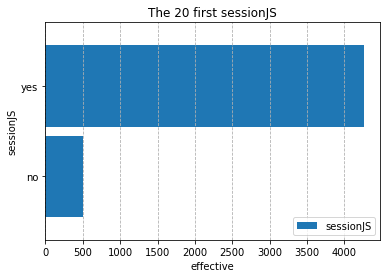

There are 0 unique terms for the attribute 'sessionJS'

The most used terms are: 
yes    4268
no      501
Name: sessionJS, dtype: int64


In [7]:
terms_analysis(df_consistent, 'sessionJS')

The distinct values for the attribute 'languageHttp' are : 
 ['de' 'pt' 'ru' 'en' 'fr' 'cs' 'da' 'it' 'nl' 'sv' 'sl' 'es' 'nb' 'hu'
 'pl' 'sh' 'ja' 'ac' 'uk' 'zh' 'tr' 'az' 'sk' 'fi' 'ko' 'th' 'vi' 'hr'
 'ro' 'an' 'ch' 'ca' 'ar' 'lt' 'el' 'af' 'bg' 'et']

    effective          %
en       2672  53.968895
ru        850  17.168249
fr        583  11.775399
de        320   6.463341
es         79   1.595637
it         61   1.232074
pl         59   1.191678
zh         57   1.151283
nl         52   1.050293
pt         42   0.848313
hu         35   0.706928
cs         21   0.424157
ja         18   0.363563
uk         13   0.262573
da         12   0.242375
tr          8   0.161584
ac          8   0.161584
sv          8   0.161584
fi          6   0.121188
vi          6   0.121188
ko          5   0.100990
sk          5   0.100990
af          4   0.080792
hr          4   0.080792
lt          3   0.060594
sl          3   0.060594
el          2   0.040396
nb          2   0.040396
sh          2   0.0

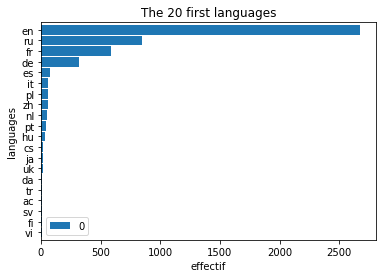

There are 7 unique terms for the attribute 'languageHttp'

The most used terms are: 
en    2672
ru     850
fr     583
de     320
es      79
Name: 0, dtype: int64


In [10]:
# terms analysis for the attribute 'languageHttp'
tmp_stats = []
ids = set(df_consistent['id'].unique())
for user_id in ids:
    df_user_id = df_consistent[df_consistent['id'] == user_id]
    different_values = df_user_id['languageHttp'].unique()
    for value in different_values:
        tmp_stats.append({
            "id": user_id,
            'languageHttp' : value
        })
df_stats = pd.DataFrame(tmp_stats)

language_http=df_stats['languageHttp']
language_http_less_nan=language_http.dropna()
language_http_less_nan_list= language_http_less_nan.values.tolist()

languages = []
for i in range(0,len(language_http_less_nan_list)):    
    languages.append(language_http_less_nan_list[i][:2])

langues_df = pd.DataFrame(languages)

print("The distinct values for the attribute 'languageHttp' are : \n {}".format(langues_df[0].unique()))

    
nb = langues_df[0].value_counts()
df_nb = pd.DataFrame(nb)
    
nb_percent = nb/nb.sum()*100
df_nb_percent = pd.DataFrame(nb_percent)
    
tab = df_nb.join(df_nb_percent, lsuffix='_left', rsuffix='_right')
tab.columns = ['effective', '%']

print()
print(tab)
print()

df_nb[:20].plot(kind='barh', stacked=False, width=0.9)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle = 'dashed')
plt.title('The 20 first languages')
plt.xlabel('effective')
plt.ylabel('languages')
plt.show()

print("There are {:d} unique terms for the attribute 'languageHttp'".format(len(nb[nb.values == 1])))
print()
print("The most used terms are: \n{}".format(nb[:5]))


In [102]:
#modality of plugins
tmp_stats = []
plugins=re.findall("Plugin [0-9]+: ([a-zA-Z -.]+)", str(df_consistent['pluginsJS']))
plugins_df=pd.DataFrame(plugins)
plugins_df[0].unique()

array(['Chrome PDF Viewer', 'Chromium PDF Viewer',
       'Default Browser Helper', 'Shockwave Flash', 'DivX',
       'Gnome Shell Integration', 'Google Update', 'Native Client',
       'Adobe Acrobat'], dtype=object)

In [8]:
def analysis_terms_splited(df, attribute, split_function):
    tmp_dataset = []
    tmp_stats = []
    ids = set(df_consistent['id'].unique())
    for user_id in ids:
        df_user_id = df_consistent[df_consistent['id'] == user_id]
        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id
            })
            values_split = split_function(value)

            for value_tmp in values_split:
                tmp_dataset.append({
                    "id": user_id,
                    attribute: value_tmp
                })

    df_tmp = pd.DataFrame(tmp_dataset)
    df_stats = pd.DataFrame(tmp_stats)
    
    nb = df_tmp[attribute].value_counts()
    df_nb = pd.DataFrame(nb)
    
    nb_percent = nb/nb.sum()*100
    df_nb_percent = pd.DataFrame(nb_percent)
    
    tab = df_nb.join(df_nb_percent, lsuffix='_left', rsuffix='_right')
    tab.columns = ['effective', '%']
    
    
    print(tab)
    print()
    
    df_nb[:20].plot(kind='barh', stacked=False, width=0.9)
    plt.gca().invert_yaxis() 
    plt.grid(axis='x', linestyle = 'dashed')
    plt.title('The 20 first {}'.format(attribute))
    plt.xlabel('effective')
    plt.ylabel(attribute)
    plt.show()
    
    print("There are {:d} unique terms for the attribute '{}'".format(len(nb[nb.values == 1]), attribute))
    print()
    print("The most used terms are: \n{}".format(nb[:5]))
    print()
    print("There are {:d} {}".format(len(nb), attribute))
    
def split_plugins(attribute):
    return re.findall("Plugin [0-9]+: ([a-zA-Z -.]+)", str(attribute))

def split_accept_http(accept):
    return accept.split(",")

def split_encoding_http(encoding):
    return encoding.split(", ")

def split_order_http(order):
    return order.split(" ")

def split_encoding_http(encoding):
    try:
        replacement=encoding.replace(","," ")
        junction=''.join(replacement)
        disjunction=junction.split()
        return disjunction 
    except:
        return [""]
 

                                                    effective          %
Chrome PDF Viewer                                        8912  14.564947
Shockwave Flash                                          8474  13.849121
Widevine Content Decryption Module                       4792   7.831601
Native Client                                            4679   7.646924
Microsoft Office                                         3228   5.275544
Adobe Acrobat                                            2889   4.721514
Google Update                                            2278   3.722952
Silverlight Plug-In                                      1862   3.043080
QuickTime Plug-in                                        1695   2.770151
JavaTM Platform SE                                       1657   2.708047
Java Deployment Toolkit                                  1591   2.600183
Intel                                                    1398   2.284762
VLC Web Plugin                                     

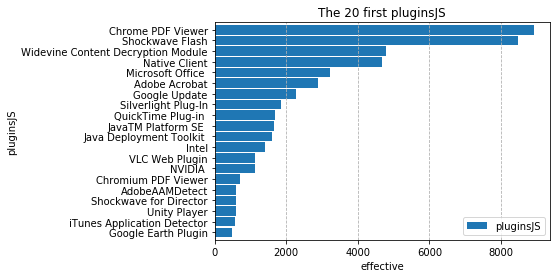

There are 106 unique terms for the attribute 'pluginsJS'

The most used terms are: 
Chrome PDF Viewer                     8912
Shockwave Flash                       8474
Widevine Content Decryption Module    4792
Native Client                         4679
Microsoft Office                      3228
Name: pluginsJS, dtype: int64

There are 460 pluginsJS


In [255]:
analysis_terms_splited(df_consistent, 'pluginsJS', split_plugins)

In [10]:
def analyze_grouped(df, attribute, group_by_attribute):
    tmp_stats = []
    ids = set(df['id'].unique())
    for user_id in ids:
        df_user_id = df[df_consistent['id'] == user_id]
        os_user = df_user_id["os"].values[0]
        browser_user = df_user_id["browserFamily"].values[0]

        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                "os": os_user,
                "browserFamily": browser_user,
                attribute: value
            })
  
    df_stats = pd.DataFrame(tmp_stats)
    stats_grouped = df_stats[group_by_attribute].value_counts()
    grouped = df_stats.groupby([attribute])
    for name, group in grouped:
        norm = 0 
        count_per_group = group[group_by_attribute].value_counts()
        for key, number in stats_grouped.iteritems():
            try:
                norm += abs(number - count_per_group[key])
            except KeyError:
                norm += abs(number)

        if norm >= 0:
            print(name)
            print(count_per_group)

        print(norm)

In [38]:
analyze_grouped(df_consistent,'localJS', 'sessionJS')

KeyError: 'sessionJS'

In [11]:
def analyze_grouped_splited(df, attribute, group_by_attribute, split_function):
    tmp_dataset = []
    tmp_stats = []
    ids = set(df['id'].unique())
    for user_id in ids:
        df_user_id = df[df['id'] == user_id]
        os_user = df_user_id["os"].values[0]
        browser_user = df_user_id["browserFamily"].values[0]

        different_values = df_user_id[attribute].unique()
        for value in different_values:
            tmp_stats.append({
                "id": user_id,
                "os": os_user,
                "browserFamily": browser_user
            })
            values_split = split_function(value)

            for value_tmp in values_split:
                tmp_dataset.append({
                    "id": user_id,
                    "os": os_user,
                    "browserFamily": browser_user,
                    attribute: value_tmp

                })

    df_tmp = pd.DataFrame(tmp_dataset)
    df_stats = pd.DataFrame(tmp_stats)
    
    
    stats_grouped = df_stats.groupby(group_by_attribute).size()
    #print(stats_grouped)
    #stats_grouped = df_stats[group_by_attribute].value_counts()
    grouped = df_tmp.groupby([attribute])
    for name, group in grouped:
        norm = 0 
        count_per_group = group.groupby(group_by_attribute).size()
        #count_per_group = group[group_by_attribute].value_counts()
        for key, number in stats_grouped.iteritems():
            try:
                norm += (number - count_per_group[key])**2
            except KeyError:
                norm += number**2

        if norm >= 0:
            print(name)
            print(count_per_group)

        print(norm)

def split_headers(headers):
    return headers.split(" ")

def split_languages_http(languages):
    try:
        return languages.split(";")
    except AttributeError:
        return str(languages)
    
def split_accept_http(accept):
    return accept.split(",")

def split_plugins(attribute):
    return re.findall("Plugin [0-9]+: ([a-zA-Z -.]+)", str(attribute))

def split_order_http(order):
    return order.split(" ")

def split_encoding_http(encoding):
    try:
        replacement=encoding.replace(","," ")
        junction=''.join(replacement)
        disjunction=junction.split()
        return disjunction 
    except:
        return [""]

In [23]:
analyze_grouped_splited(df_consistent, 'encodingHttp', 'browserFamily', split_encoding_http)


browserFamily
Firefox    3
dtype: int64
11703118
br
browserFamily
Chrome            1597
Chromium            43
Dragon               3
Epiphany             1
Firefox           1912
IE Mobile            1
Iceweasel            3
Iron                28
Konqueror            1
Opera                8
Other                5
QupZilla             1
Rekonq               1
SeaMonkey            1
Vivaldi             38
Yandex Browser       4
dtype: int64
876300
bzip2
browserFamily
Chrome    1
dtype: int64
11713896
compress
browserFamily
Chrome    1
dtype: int64
11713896
deflate
browserFamily
Chrome                         2274
Chromium                         72
Dragon                            9
Epiphany                          2
Firefox                        2553
IE Mobile                         1
Iceweasel                        32
Iron                             37
Konqueror                         1
Maxthon                           1
Opera                            15
Other           

In [165]:
analyze_grouped_splited(df_consistent, 'vendorWebGLJS', ['os', 'browserFamily'], split_plugins)

os             browserFamily              
Chrome OS      Chrome                          72
FreeBSD        Chrome                           1
               Firefox                          3
Linux          Chrome                         304
               Firefox                        177
               Iceweasel                       32
               Iron                             6
               Konqueror                        1
               Opera                            1
               QupZilla                         1
               Rekonq                           1
               Vivaldi                         14
Mac OS X       Chrome                         390
               Firefox                        191
               Iron                             1
               Opera                            2
               SeaMonkey                        1
               Vivaldi                          6
NetBSD         Firefox                          1
OpenBSD

KeyError: 'vendorWebGLJS'

In [143]:
analyse_terms_splited(df_consistent,'encodingHttp',split_function=lambda encoding: encoding.split(","))

AttributeError: 'float' object has no attribute 'split'

## Inconsistent fingerprint detection

In [48]:
# Détection of inconsistent values
df_consistent[df_consistent['browserFamily']== "IE Mobile"]["os"]

87094    Other
87096    Other
87097    Other
Name: os, dtype: object

In [49]:
# N° of the fingerprint to take off it from consistent fingerprints
df_consistent[df_consistent['browserFamily'] == "IE Mobile"]["id"]

87094    d2869d31-770a-4e4a-b91a-331c47e1e144
87096    d2869d31-770a-4e4a-b91a-331c47e1e144
87097    d2869d31-770a-4e4a-b91a-331c47e1e144
Name: id, dtype: object

In [52]:
df_consistent[df_consistent['id']== "d2869d31-770a-4e4a-b91a-331c47e1e144"]

counter                                    id         creationDate  \
87094   117423  d2869d31-770a-4e4a-b91a-331c47e1e144  2017-02-10 09:00:00   
87096   117425  d2869d31-770a-4e4a-b91a-331c47e1e144  2017-02-10 09:00:00   
87097   117427  d2869d31-770a-4e4a-b91a-331c47e1e144  2017-02-10 09:00:00   

                   endDate                               addressHttp  \
87094  2017-02-10 09:00:00  2f998c35b04d46117baa579021107c4911fd8387   
87096  2017-02-10 09:00:00  2f998c35b04d46117baa579021107c4911fd8387   
87097                 None  2f998c35b04d46117baa579021107c4911fd8387   

                                           userAgentHttp  \
87094  safari (compatible; MSIE 9.0; samsung Phone OS...   
87096  safari (compatible; MSIE 9.0; samsung Phone OS...   
87097  safari (compatible; MSIE 9.0; samsung Phone OS...   

                                              acceptHttp connectionHttp  \
87094  text/html,application/xhtml+xml,application/xm...          close   
87096  text/html,application/xhtml+xml,application/xm...          close   
87097  text/html,application/xhtml+xml,application/xm...          close   

            encodingHttp    languageHttp    ...           platformFlash  \
87094  gzip, deflate, br  en-US,en;q=0.5    ...      Flash not detected   
87096  gzip, deflate, br  en-US,en;q=0.8    ...      Flash not detected   
87097  gzip, deflate, br           en-us    ...      Flash not detected   

      browserFamily globalBrowserVersion minorBrowserVersion  \
87094     IE Mobile                   90                   0   
87096     IE Mobile                   90                   0   
87097     IE Mobile                   90                   0   

      majorBrowserVersion     os rendererWebGLJS  vendorWebGLJS pluginsJS  \
87094                   9  Other   Not supported  Not supported       NaN   
87096                   9  Other   Not supported  Not supported       NaN   
87097                   9  Other   Not supported  Not supported       NaN   

      consistent  
87094       True  
87096       True  
87097       True  

[3 rows x 33 columns]

## Temporal analysis of consistent fingerprints

In [6]:
#id with more 2 fingerprints
number_fingerprints_by_id=df_consistent['id'].value_counts()
df_number_fingerprints_by_id=pd.DataFrame(number_fingerprints_by_id)
user_more_2_fingerprints=[]
for user_id, number in df_number_fingerprints_by_id.iteritems():
    for i in range(0, len(number)):
        if number[i] != 1:
            user_more_2_fingerprints.append({
                "valeur":number[i],
                "index":number.index[i]
            })
            
df_user_more_2_fingerprints=pd.DataFrame(user_more_2_fingerprints)

### Number of plugins in time

In [8]:
print("The following analysis is done from {} to {}".format(min(df_consistent['creationDate']),max(df_consistent['creationDate'])))

The following analysis is done from 2015-07-27 11:00:00 to 2017-03-13 01:00:00


In [9]:
evolution=[]
for user_id in df_user_more_2_fingerprints['index']:
    date=df_consistent[df_consistent['id']==user_id]['creationDate']   
    year_month=[]
    for key, line in date.iteritems():
        year_month.append({
            "cle": key,
            "Date":line[:7]
        })

    df_year_month = pd.DataFrame(year_month)
    
    plugins = df_consistent[df_consistent['id']==user_id]['pluginsJS']
    df_plugins = pd.DataFrame(plugins)
    nb_plugins = df_plugins['pluginsJS']
    liste=[]
    for key, line in nb_plugins.iteritems():
        liste.append({
            "cle": key,
            "number of plugins":len(str(line).split(":"))-1
        })
          
    df_liste = pd.DataFrame(liste)
    annee_mois_nb_plugins = df_year_month.join(df_liste['number of plugins'])
    
    #obtenir le dernier: -1 pour la dernière ligne et 2 pour la colonne 'number of plugins'
    nb_fin=annee_mois_nb_plugins.iloc[-1,2]
    nb_debut=annee_mois_nb_plugins.iloc[0,2]
    nb_final=nb_fin-nb_debut

    list_final = []
    list_final.append(nb_final)
    df_list_final = pd.DataFrame(list_final)
    evolution.append(nb_final)
    
count_inf=0
count_sup=0
count_zero=0
for i in range(0,len(evolution)):
    if evolution[i]<0:
        count_inf=count_inf+1
    elif evolution[i]>0:
        count_sup=count_sup+1
    else:
        count_zero=count_zero+1
print("The number of plugins decreases for {:d} id".format(count_inf))
print("The number of plugins increases for {:d} id".format(count_sup))
print("The number of plugins stagnates for {:d} id".format(count_zero))
print("Conclusion: over time, the number of plugins tends to stagnate")

The number of plugins decreases for 679 id
The number of plugins increases for 300 id
The number of plugins stagnates for 1547 id
Conclusion: over time, the number of plugins tends to stagnate


### Frequency of attributes changes

#### In general

In [10]:
# Frequency of changes of each attributes independently of users
attribute_values =df_consistent['id']
list_attribute_values = list(attribute_values)
counter=0

for i in range(1,len(list_attribute_values)):
    table=[]
    if list_attribute_values[i-1] != list_attribute_values[i]:
        counter+=1
    else:
        counter=counter
    frequency = counter/len(list_attribute_values)

table.append({
    "Attributes" : 'id',
    "Frequency of changes" : frequency
})


df_table_id = pd.DataFrame(table)


attributes_to_analyze_2 = [attribute for attribute in attributes_to_analyze if attribute not in 'id']

table=[]
for attribute in attributes_to_analyze_2:
    
    attribute_values =df_consistent[attribute]
    list_attribute_values = list(attribute_values)
    counter=0

    for i in range(1,len(list_attribute_values)):
        if list_attribute_values[i-1] != list_attribute_values[i]:
            counter+=1
        else:
            counter=counter
        frequency = counter/len(list_attribute_values)

    table.append({
        "Attributes" : attribute,
        "Frequency of changes" : frequency
    })


    df_table = pd.DataFrame(table)
    df_table_all = pd.concat([ df_table_id,df_table]).sort_values(by="Frequency of changes", ascending=False).reset_index(drop=True)
print("Frequency of changes of each attributes independently of users \n {} ".format(df_table_all))
print("Nous pouvons remarquer que l'attribut 'id' change souvent. Cela peut s'expliquer par le fait que l'on réalise \nune analyse indépendante des utilisateurs donc on prend également ceux qui ont 1 seule empreinte.")

Frequency of changes of each attributes independently of users 
               Attributes  Frequency of changes
0                     id              0.979704
1            addressHttp              0.978446
2          userAgentHttp              0.948530
3         canvasJSHashed              0.932881
4       fontsFlashHashed              0.887824
5              pluginsJS              0.883644
6           languageHttp              0.883177
7        pluginsJSHashed              0.881167
8           resolutionJS              0.852591
9        resolutionFlash              0.842666
10         platformFlash              0.828215
11       rendererWebGLJS              0.786081
12             orderHttp              0.773092
13                    os              0.767328
14         languageFlash              0.736478
15            timezoneJS              0.705364
16  globalBrowserVersion              0.664914
17   majorBrowserVersion              0.664711
18         vendorWebGLJS              0.66

In [11]:
#To do : concaténer les datasets pour faire une analyse par ligne
#Frequency of changes of attributes by id (Tout le monde change-il aussi souvent ?)

x=pd.DataFrame(attributes_to_analyze)

for user_id in df_user_more_2_fingerprints['index']:
    table=[]
    person=df_consistent[df_consistent['id']== user_id]

    for attribute in attributes_to_analyze:
    
        attribute_values =person[attribute]
        list_attribute_values = list(attribute_values)
        counter=0
        
        for i in range(1,len(list_attribute_values)):
            if list_attribute_values[i-1] != list_attribute_values[i]:
                counter+=1
            else:
                counter=counter
            frequency = counter/len(list_attribute_values)

        table.append({
            "Attributes" : attribute,
            "Frequency of changes" : frequency
        })

        
    df_table = pd.DataFrame(table)
   # print(df_table)
    
    tab = pd.concat([x,df_table["Frequency of changes"]], axis=1)
    print(tab)


                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.882850
2          userAgentHttp              0.001208
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.001208
8        pluginsJSHashed              0.007246
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.579710
13          resolutionJS              0.000000
14               localJS              0.004831
15             sessionJS              0.004831
16        canvasJSHashed              0.001208
17      fontsFlashHashed              0.053140
18       resolutionFlash              0.050725
19         languageFlash              0.050725
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.814394
2          userAgentHttp              0.071970
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.003788
6           languageHttp              0.000000
7              orderHttp              0.003788
8        pluginsJSHashed              0.034091
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.022727
13          resolutionJS              0.196970
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.757576
18       resolutionFlash              0.731061
19         languageFlash              0.704545
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.840000
2          userAgentHttp              0.073333
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.006667
6           languageHttp              0.000000
7              orderHttp              0.006667
8        pluginsJSHashed              0.033333
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.086667
13          resolutionJS              0.780000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.006667
17      fontsFlashHashed              0.180000
18       resolutionFlash              0.793333
19         languageFlash              0.026667
20         pl

                       0  Frequency of changes
0                     id                 0.000
1            addressHttp                 0.776
2          userAgentHttp                 0.128
3             acceptHttp                 0.000
4         connectionHttp                 0.000
5           encodingHttp                 0.008
6           languageHttp                 0.000
7              orderHttp                 0.008
8        pluginsJSHashed                 0.064
9             platformJS                 0.000
10             cookiesJS                 0.000
11                 dntJS                 0.000
12            timezoneJS                 0.016
13          resolutionJS                 0.344
14               localJS                 0.000
15             sessionJS                 0.000
16        canvasJSHashed                 0.016
17      fontsFlashHashed                 0.744
18       resolutionFlash                 0.752
19         languageFlash                 0.528
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.923077
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.009615
8        pluginsJSHashed              0.096154
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.009615
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.096154
18       resolutionFlash              0.096154
19         languageFlash              0.096154
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.242105
2          userAgentHttp              0.010526
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.010526
7              orderHttp              0.000000
8        pluginsJSHashed              0.021053
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.010526
13          resolutionJS              0.915789
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.105263
17      fontsFlashHashed              0.031579
18       resolutionFlash              0.905263
19         languageFlash              0.010526
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.931034
2          userAgentHttp              0.068966
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.011494
8        pluginsJSHashed              0.252874
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.011494
13          resolutionJS              0.057471
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.022989
17      fontsFlashHashed              0.724138
18       resolutionFlash              0.712644
19         languageFlash              0.701149
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.448718
2          userAgentHttp              0.153846
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.038462
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.641026
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.012821
17      fontsFlashHashed              0.397436
18       resolutionFlash              0.717949
19         languageFlash              0.102564
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.652174
2          userAgentHttp              0.057971
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.014493
8        pluginsJSHashed              0.072464
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.014493
13          resolutionJS              0.927536
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.043478
17      fontsFlashHashed              0.057971
18       resolutionFlash              0.913043
19         languageFlash              0.028986
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.444444
2          userAgentHttp              0.063492
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.015873
6           languageHttp              0.000000
7              orderHttp              0.031746
8        pluginsJSHashed              0.015873
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.095238
13          resolutionJS              0.476190
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.126984
18       resolutionFlash              0.746032
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.457627
2          userAgentHttp              0.033898
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.016949
8        pluginsJSHashed              0.050847
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.016949
13          resolutionJS              0.728814
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.338983
18       resolutionFlash              0.779661
19         languageFlash              0.067797
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.236364
2          userAgentHttp              0.090909
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.036364
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.909091
18       resolutionFlash              0.036364
19         languageFlash              0.072727
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.653846
2          userAgentHttp              0.038462
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.019231
6           languageHttp              0.000000
7              orderHttp              0.038462
8        pluginsJSHashed              0.192308
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.019231
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.038462
17      fontsFlashHashed              0.807692
18       resolutionFlash              0.307692
19         languageFlash              0.307692
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.083333
2          userAgentHttp              0.083333
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.020833
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.083333
9             platformJS              0.020833
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.916667
14               localJS              0.020833
15             sessionJS              0.020833
16        canvasJSHashed              0.062500
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.977778
2          userAgentHttp              0.022222
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.022222
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.022222
17      fontsFlashHashed              0.888889
18       resolutionFlash              0.888889
19         languageFlash              0.888889
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.666667
2          userAgentHttp              0.023810
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.023810
8        pluginsJSHashed              0.071429
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.904762
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.142857
18       resolutionFlash              0.904762
19         languageFlash              0.095238
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.179487
2          userAgentHttp              0.256410
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.025641
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.128205
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.025641
13          resolutionJS              0.153846
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.615385
18       resolutionFlash              0.256410
19         languageFlash              0.102564
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.810811
2          userAgentHttp              0.027027
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.027027
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.891892
18       resolutionFlash              0.567568
19         languageFlash              0.567568
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.085714
2          userAgentHttp              0.171429
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.057143
8        pluginsJSHashed              0.400000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.057143
13          resolutionJS              0.000000
14               localJS              0.028571
15             sessionJS              0.028571
16        canvasJSHashed              0.085714
17      fontsFlashHashed              0.771429
18       resolutionFlash              0.685714
19         languageFlash              0.685714
20         pl

                       0  Frequency of changes
0                     id               0.00000
1            addressHttp               0.34375
2          userAgentHttp               0.50000
3             acceptHttp               0.00000
4         connectionHttp               0.00000
5           encodingHttp               0.03125
6           languageHttp               0.03125
7              orderHttp               0.00000
8        pluginsJSHashed               0.31250
9             platformJS               0.00000
10             cookiesJS               0.00000
11                 dntJS               0.00000
12            timezoneJS               0.03125
13          resolutionJS               0.00000
14               localJS               0.00000
15             sessionJS               0.00000
16        canvasJSHashed               0.03125
17      fontsFlashHashed               0.28125
18       resolutionFlash               0.09375
19         languageFlash               0.09375
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.000000
2          userAgentHttp              0.032258
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.032258
8        pluginsJSHashed              0.032258
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.838710
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.129032
18       resolutionFlash              0.903226
19         languageFlash              0.129032
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.034483
2          userAgentHttp              0.068966
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.034483
7              orderHttp              0.068966
8        pluginsJSHashed              0.862069
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.103448
18       resolutionFlash              0.034483
19         languageFlash              0.034483
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.428571
2          userAgentHttp              0.142857
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.035714
8        pluginsJSHashed              0.071429
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.035714
13          resolutionJS              0.214286
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.857143
18       resolutionFlash              0.500000
19         languageFlash              0.357143
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.384615
2          userAgentHttp              0.384615
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.038462
6           languageHttp              0.000000
7              orderHttp              0.076923
8        pluginsJSHashed              0.153846
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.038462
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.615385
18       resolutionFlash              0.423077
19         languageFlash              0.423077
20         pl

                       0  Frequency of changes
0                     id                  0.00
1            addressHttp                  0.72
2          userAgentHttp                  0.04
3             acceptHttp                  0.00
4         connectionHttp                  0.00
5           encodingHttp                  0.00
6           languageHttp                  0.00
7              orderHttp                  0.00
8        pluginsJSHashed                  0.00
9             platformJS                  0.00
10             cookiesJS                  0.00
11                 dntJS                  0.00
12            timezoneJS                  0.00
13          resolutionJS                  0.60
14               localJS                  0.00
15             sessionJS                  0.00
16        canvasJSHashed                  0.00
17      fontsFlashHashed                  0.64
18       resolutionFlash                  0.92
19         languageFlash                  0.64
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.791667
2          userAgentHttp              0.333333
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.041667
7              orderHttp              0.041667
8        pluginsJSHashed              0.375000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.041667
12            timezoneJS              0.041667
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.083333
17      fontsFlashHashed              0.666667
18       resolutionFlash              0.666667
19         languageFlash              0.666667
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.304348
2          userAgentHttp              0.173913
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.043478
8        pluginsJSHashed              0.565217
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.130435
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.130435
17      fontsFlashHashed              0.434783
18       resolutionFlash              0.434783
19         languageFlash              0.434783
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.545455
2          userAgentHttp              0.045455
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.045455
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.045455
13          resolutionJS              0.863636
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.181818
18       resolutionFlash              0.863636
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.904762
2          userAgentHttp              0.095238
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.047619
8        pluginsJSHashed              0.095238
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.047619
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.285714
2          userAgentHttp              0.571429
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.047619
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.190476
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.238095
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.095238
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id                  0.00
1            addressHttp                  0.05
2          userAgentHttp                  0.15
3             acceptHttp                  0.00
4         connectionHttp                  0.00
5           encodingHttp                  0.00
6           languageHttp                  0.00
7              orderHttp                  0.15
8        pluginsJSHashed                  0.55
9             platformJS                  0.00
10             cookiesJS                  0.00
11                 dntJS                  0.10
12            timezoneJS                  0.00
13          resolutionJS                  0.00
14               localJS                  0.00
15             sessionJS                  0.00
16        canvasJSHashed                  0.10
17      fontsFlashHashed                  0.30
18       resolutionFlash                  0.15
19         languageFlash                  0.15
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.684211
2          userAgentHttp              0.105263
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.052632
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.842105
18       resolutionFlash              0.526316
19         languageFlash              0.526316
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.210526
2          userAgentHttp              0.105263
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.052632
7              orderHttp              0.000000
8        pluginsJSHashed              0.105263
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.052632
13          resolutionJS              0.789474
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.105263
18       resolutionFlash              0.842105
19         languageFlash              0.105263
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.000000
2          userAgentHttp              0.277778
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.055556
8        pluginsJSHashed              0.222222
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.333333
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.333333
17      fontsFlashHashed              0.333333
18       resolutionFlash              0.333333
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.470588
2          userAgentHttp              0.117647
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.235294
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.058824
13          resolutionJS              0.294118
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.058824
17      fontsFlashHashed              0.294118
18       resolutionFlash              0.529412
19         languageFlash              0.235294
20         pl

                       0  Frequency of changes
0                     id                0.0000
1            addressHttp                0.4375
2          userAgentHttp                0.2500
3             acceptHttp                0.0000
4         connectionHttp                0.0000
5           encodingHttp                0.0000
6           languageHttp                0.0000
7              orderHttp                0.1250
8        pluginsJSHashed                0.0625
9             platformJS                0.0000
10             cookiesJS                0.0000
11                 dntJS                0.0625
12            timezoneJS                0.6875
13          resolutionJS                0.0000
14               localJS                0.0000
15             sessionJS                0.0000
16        canvasJSHashed                0.1875
17      fontsFlashHashed                0.0625
18       resolutionFlash                0.0625
19         languageFlash                0.0625
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.533333
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.266667
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.800000
18       resolutionFlash              0.066667
19         languageFlash              0.066667
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.866667
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.133333
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.066667
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.600000
18       resolutionFlash              0.533333
19         languageFlash              0.533333
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.071429
2          userAgentHttp              0.142857
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.071429
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.714286
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.071429
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.071429
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.384615
2          userAgentHttp              0.230769
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.230769
8        pluginsJSHashed              0.230769
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.153846
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.615385
18       resolutionFlash              0.615385
19         languageFlash              0.538462
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.461538
2          userAgentHttp              0.692308
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.153846
8        pluginsJSHashed              0.307692
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.230769
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.076923
17      fontsFlashHashed              0.384615
18       resolutionFlash              0.307692
19         languageFlash              0.307692
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.000000
2          userAgentHttp              0.083333
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.083333
8        pluginsJSHashed              0.166667
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.083333
12            timezoneJS              0.083333
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.083333
17      fontsFlashHashed              0.666667
18       resolutionFlash              0.166667
19         languageFlash              0.166667
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.833333
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.083333
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.416667
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.083333
17      fontsFlashHashed              0.666667
18       resolutionFlash              0.666667
19         languageFlash              0.666667
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.666667
2          userAgentHttp              0.166667
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.083333
8        pluginsJSHashed              0.250000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.166667
17      fontsFlashHashed              0.166667
18       resolutionFlash              0.166667
19         languageFlash              0.166667
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.909091
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.090909
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.090909
12            timezoneJS              0.454545
13          resolutionJS              0.363636
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.363636
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.818182
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.090909
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.636364
18       resolutionFlash              0.636364
19         languageFlash              0.636364
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.1
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.1
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.1
13          resolutionJS                   0.5
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.3
18       resolutionFlash                   0.1
19         languageFlash                   0.1
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.6
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.2
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.1
13          resolutionJS                   0.2
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.4
18       resolutionFlash                   0.2
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.1
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.1
8        pluginsJSHashed                   0.3
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.4
17      fontsFlashHashed                   0.3
18       resolutionFlash                   0.1
19         languageFlash                   0.1
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.666667
2          userAgentHttp              0.111111
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.222222
8        pluginsJSHashed              0.222222
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.444444
18       resolutionFlash              0.444444
19         languageFlash              0.444444
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.888889
2          userAgentHttp              0.222222
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.222222
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.111111
13          resolutionJS              0.222222
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.111111
17      fontsFlashHashed              0.444444
18       resolutionFlash              0.222222
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.333333
2          userAgentHttp              0.555556
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.222222
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.222222
11                 dntJS              0.111111
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.111111
15             sessionJS              0.111111
16        canvasJSHashed              0.111111
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id                 0.000
1            addressHttp                 0.125
2          userAgentHttp                 0.375
3             acceptHttp                 0.000
4         connectionHttp                 0.000
5           encodingHttp                 0.000
6           languageHttp                 0.000
7              orderHttp                 0.125
8        pluginsJSHashed                 0.375
9             platformJS                 0.000
10             cookiesJS                 0.000
11                 dntJS                 0.000
12            timezoneJS                 0.125
13          resolutionJS                 0.000
14               localJS                 0.000
15             sessionJS                 0.000
16        canvasJSHashed                 0.000
17      fontsFlashHashed                 0.375
18       resolutionFlash                 0.375
19         languageFlash                 0.375
20         pl

                       0  Frequency of changes
0                     id                 0.000
1            addressHttp                 0.750
2          userAgentHttp                 0.125
3             acceptHttp                 0.000
4         connectionHttp                 0.000
5           encodingHttp                 0.000
6           languageHttp                 0.000
7              orderHttp                 0.000
8        pluginsJSHashed                 0.375
9             platformJS                 0.000
10             cookiesJS                 0.000
11                 dntJS                 0.000
12            timezoneJS                 0.000
13          resolutionJS                 0.000
14               localJS                 0.000
15             sessionJS                 0.000
16        canvasJSHashed                 0.000
17      fontsFlashHashed                 0.500
18       resolutionFlash                 0.375
19         languageFlash                 0.375
20         pl

                       0  Frequency of changes
0                     id                 0.000
1            addressHttp                 0.000
2          userAgentHttp                 0.500
3             acceptHttp                 0.000
4         connectionHttp                 0.000
5           encodingHttp                 0.000
6           languageHttp                 0.000
7              orderHttp                 0.000
8        pluginsJSHashed                 0.000
9             platformJS                 0.000
10             cookiesJS                 0.000
11                 dntJS                 0.000
12            timezoneJS                 0.000
13          resolutionJS                 0.625
14               localJS                 0.000
15             sessionJS                 0.000
16        canvasJSHashed                 0.000
17      fontsFlashHashed                 0.000
18       resolutionFlash                 0.000
19         languageFlash                 0.000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.714286
2          userAgentHttp              0.142857
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.142857
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.142857
17      fontsFlashHashed              0.571429
18       resolutionFlash              0.428571
19         languageFlash              0.428571
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.285714
2          userAgentHttp              0.142857
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.142857
17      fontsFlashHashed              0.571429
18       resolutionFlash              0.571429
19         languageFlash              0.571429
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.571429
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.142857
7              orderHttp              0.285714
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.714286
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.000000
2          userAgentHttp              0.571429
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.142857
8        pluginsJSHashed              0.142857
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.285714
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.428571
18       resolutionFlash              0.428571
19         languageFlash              0.428571
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.000000
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.833333
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.833333
2          userAgentHttp              0.500000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.166667
8        pluginsJSHashed              0.500000
9             platformJS              0.500000
10             cookiesJS              0.000000
11                 dntJS              0.166667
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.333333
2          userAgentHttp              0.166667
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.166667
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.166667
12            timezoneJS              0.166667
13          resolutionJS              0.333333
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.166667
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.000000
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.666667
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.333333
18       resolutionFlash              0.666667
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.333333
2          userAgentHttp              0.166667
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.666667
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.166667
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.166667
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.8
2          userAgentHttp                   0.2
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.2
8        pluginsJSHashed                   0.2
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.2
12            timezoneJS                   0.2
13          resolutionJS                   0.4
14               localJS                   0.2
15             sessionJS                   0.2
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.2
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.6
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.6
18       resolutionFlash                   0.6
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.8
2          userAgentHttp                   0.4
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.2
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.2
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.8
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.2
18       resolutionFlash                   0.2
19         languageFlash                   0.2
20         pl

28             pluginsJS                   0.4
                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.8
2          userAgentHttp                   0.4
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.6
7              orderHttp                   0.4
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.2
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.4
17      fontsFlashHashed                   0.4
18       resolutionFlash                   0.4
19         la

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.2
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.8
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.8
2          userAgentHttp                   0.4
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.2
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.2
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.4
9             platformJS                   0.0
10             cookiesJS                   0.2
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.2
15             sessionJS                   0.2
16        canvasJSHashed                   0.2
17      fontsFlashHashed                   0.4
18       resolutionFlash                   0.4
19         languageFlash                   0.4
20         pl

                       0  Frequency of changes
0                     id                  0.00
1            addressHttp                  0.00
2          userAgentHttp                  0.50
3             acceptHttp                  0.00
4         connectionHttp                  0.00
5           encodingHttp                  0.00
6           languageHttp                  0.00
7              orderHttp                  0.50
8        pluginsJSHashed                  0.50
9             platformJS                  0.00
10             cookiesJS                  0.00
11                 dntJS                  0.25
12            timezoneJS                  0.25
13          resolutionJS                  0.25
14               localJS                  0.00
15             sessionJS                  0.00
16        canvasJSHashed                  0.25
17      fontsFlashHashed                  0.75
18       resolutionFlash                  0.75
19         languageFlash                  0.75
20         pl

                       0  Frequency of changes
0                     id                  0.00
1            addressHttp                  0.00
2          userAgentHttp                  0.00
3             acceptHttp                  0.00
4         connectionHttp                  0.00
5           encodingHttp                  0.00
6           languageHttp                  0.00
7              orderHttp                  0.00
8        pluginsJSHashed                  0.50
9             platformJS                  0.00
10             cookiesJS                  0.00
11                 dntJS                  0.00
12            timezoneJS                  0.00
13          resolutionJS                  0.00
14               localJS                  0.00
15             sessionJS                  0.00
16        canvasJSHashed                  0.00
17      fontsFlashHashed                  0.25
18       resolutionFlash                  0.00
19         languageFlash                  0.00
20         pl

                       0  Frequency of changes
0                     id                  0.00
1            addressHttp                  0.00
2          userAgentHttp                  0.00
3             acceptHttp                  0.00
4         connectionHttp                  0.00
5           encodingHttp                  0.00
6           languageHttp                  0.00
7              orderHttp                  0.25
8        pluginsJSHashed                  0.00
9             platformJS                  0.00
10             cookiesJS                  0.00
11                 dntJS                  0.25
12            timezoneJS                  0.00
13          resolutionJS                  0.50
14               localJS                  0.00
15             sessionJS                  0.00
16        canvasJSHashed                  0.00
17      fontsFlashHashed                  0.25
18       resolutionFlash                  0.50
19         languageFlash                  0.00
20         pl

                       0  Frequency of changes
0                     id                  0.00
1            addressHttp                  0.00
2          userAgentHttp                  0.25
3             acceptHttp                  0.00
4         connectionHttp                  0.00
5           encodingHttp                  0.25
6           languageHttp                  0.00
7              orderHttp                  0.25
8        pluginsJSHashed                  0.00
9             platformJS                  0.00
10             cookiesJS                  0.00
11                 dntJS                  0.25
12            timezoneJS                  0.00
13          resolutionJS                  0.00
14               localJS                  0.00
15             sessionJS                  0.00
16        canvasJSHashed                  0.00
17      fontsFlashHashed                  0.00
18       resolutionFlash                  0.00
19         languageFlash                  0.25
20         pl

                       0  Frequency of changes
0                     id                  0.00
1            addressHttp                  0.75
2          userAgentHttp                  0.50
3             acceptHttp                  0.00
4         connectionHttp                  0.00
5           encodingHttp                  0.25
6           languageHttp                  0.25
7              orderHttp                  0.00
8        pluginsJSHashed                  0.00
9             platformJS                  0.00
10             cookiesJS                  0.00
11                 dntJS                  0.00
12            timezoneJS                  0.25
13          resolutionJS                  0.25
14               localJS                  0.00
15             sessionJS                  0.00
16        canvasJSHashed                  0.00
17      fontsFlashHashed                  0.00
18       resolutionFlash                  0.00
19         languageFlash                  0.00
20         pl

                       0  Frequency of changes
0                     id                  0.00
1            addressHttp                  0.25
2          userAgentHttp                  0.25
3             acceptHttp                  0.00
4         connectionHttp                  0.00
5           encodingHttp                  0.25
6           languageHttp                  0.00
7              orderHttp                  0.25
8        pluginsJSHashed                  0.25
9             platformJS                  0.00
10             cookiesJS                  0.00
11                 dntJS                  0.00
12            timezoneJS                  0.00
13          resolutionJS                  0.50
14               localJS                  0.00
15             sessionJS                  0.00
16        canvasJSHashed                  0.00
17      fontsFlashHashed                  0.25
18       resolutionFlash                  0.50
19         languageFlash                  0.00
20         pl

                       0  Frequency of changes
0                     id                  0.00
1            addressHttp                  0.00
2          userAgentHttp                  0.25
3             acceptHttp                  0.00
4         connectionHttp                  0.00
5           encodingHttp                  0.00
6           languageHttp                  0.00
7              orderHttp                  0.00
8        pluginsJSHashed                  0.25
9             platformJS                  0.00
10             cookiesJS                  0.00
11                 dntJS                  0.00
12            timezoneJS                  0.00
13          resolutionJS                  0.00
14               localJS                  0.00
15             sessionJS                  0.00
16        canvasJSHashed                  0.00
17      fontsFlashHashed                  0.25
18       resolutionFlash                  0.00
19         languageFlash                  0.00
20         pl

                       0  Frequency of changes
0                     id                  0.00
1            addressHttp                  0.25
2          userAgentHttp                  0.00
3             acceptHttp                  0.00
4         connectionHttp                  0.00
5           encodingHttp                  0.00
6           languageHttp                  0.50
7              orderHttp                  0.25
8        pluginsJSHashed                  0.00
9             platformJS                  0.00
10             cookiesJS                  0.00
11                 dntJS                  0.00
12            timezoneJS                  0.25
13          resolutionJS                  0.00
14               localJS                  0.00
15             sessionJS                  0.00
16        canvasJSHashed                  0.00
17      fontsFlashHashed                  0.00
18       resolutionFlash                  0.00
19         languageFlash                  0.00
20         pl

                       0  Frequency of changes
0                     id                  0.00
1            addressHttp                  0.00
2          userAgentHttp                  0.00
3             acceptHttp                  0.00
4         connectionHttp                  0.00
5           encodingHttp                  0.00
6           languageHttp                  0.00
7              orderHttp                  0.00
8        pluginsJSHashed                  0.00
9             platformJS                  0.00
10             cookiesJS                  0.00
11                 dntJS                  0.00
12            timezoneJS                  0.00
13          resolutionJS                  0.50
14               localJS                  0.00
15             sessionJS                  0.00
16        canvasJSHashed                  0.00
17      fontsFlashHashed                  0.25
18       resolutionFlash                  0.50
19         languageFlash                  0.00
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.5
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.5
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.5
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.666667
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.666667
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.333333
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.666667
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.333333
2          userAgentHttp              0.333333
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.333333
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.333333
18       resolutionFlash              0.333333
19         languageFlash              0.333333
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.000000
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.666667
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.666667
2          userAgentHttp              0.666667
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.333333
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.666667
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.000000
2          userAgentHttp              0.333333
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.333333
8        pluginsJSHashed              0.333333
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.666667
13          resolutionJS              0.333333
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.333333
18       resolutionFlash              0.333333
19         languageFlash              0.333333
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.333333
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.333333
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.666667
18       resolutionFlash              0.666667
19         languageFlash              0.666667
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.666667
2          userAgentHttp              0.333333
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.666667
18       resolutionFlash              0.666667
19         languageFlash              0.666667
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.666667
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.333333
8        pluginsJSHashed              0.666667
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.333333
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.000000
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.666667
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.666667
18       resolutionFlash              0.666667
19         languageFlash              0.666667
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.666667
2          userAgentHttp              0.333333
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.333333
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.000000
15             sessionJS              0.000000
16        canvasJSHashed              0.333333
17      fontsFlashHashed              0.666667
18       resolutionFlash              0.666667
19         languageFlash              0.666667
20         pl

                       0  Frequency of changes
0                     id              0.000000
1            addressHttp              0.333333
2          userAgentHttp              0.000000
3             acceptHttp              0.000000
4         connectionHttp              0.000000
5           encodingHttp              0.000000
6           languageHttp              0.000000
7              orderHttp              0.000000
8        pluginsJSHashed              0.000000
9             platformJS              0.000000
10             cookiesJS              0.000000
11                 dntJS              0.000000
12            timezoneJS              0.000000
13          resolutionJS              0.000000
14               localJS              0.333333
15             sessionJS              0.333333
16        canvasJSHashed              0.000000
17      fontsFlashHashed              0.000000
18       resolutionFlash              0.000000
19         languageFlash              0.000000
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.5
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.5
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.5
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.5
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.5
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.5
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.5
17      fontsFlashHashed                   0.5
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.5
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.5
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.5
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.5
15             sessionJS                   0.5
16        canvasJSHashed                   0.5
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.5
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.5
18       resolutionFlash                   0.5
19         languageFlash                   0.5
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.5
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.5
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.5
18       resolutionFlash                   0.5
19         languageFlash                   0.5
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.5
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.5
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.5
18       resolutionFlash                   0.5
19         languageFlash                   0.5
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.5
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.5
18       resolutionFlash                   0.5
19         languageFlash                   0.5
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.5
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.5
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.5
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.5
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.5
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.5
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.5
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.5
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.5
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.5
18       resolutionFlash                   0.5
19         languageFlash                   0.5
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.5
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.5
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.5
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.5
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.5
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.5
2          userAgentHttp                   0.5
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.5
7              orderHttp                   0.5
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.0
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.0
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.5
18       resolutionFlash                   0.0
19         languageFlash                   0.0
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.5
2          userAgentHttp                   0.0
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.5
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.5
18       resolutionFlash                   0.5
19         languageFlash                   0.5
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.0
2          userAgentHttp                   0.5
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.5
8        pluginsJSHashed                   0.5
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.5
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.5
18       resolutionFlash                   0.5
19         languageFlash                   0.5
20         pl

                       0  Frequency of changes
0                     id                   0.0
1            addressHttp                   0.5
2          userAgentHttp                   0.5
3             acceptHttp                   0.0
4         connectionHttp                   0.0
5           encodingHttp                   0.0
6           languageHttp                   0.0
7              orderHttp                   0.0
8        pluginsJSHashed                   0.5
9             platformJS                   0.0
10             cookiesJS                   0.0
11                 dntJS                   0.0
12            timezoneJS                   0.0
13          resolutionJS                   0.0
14               localJS                   0.0
15             sessionJS                   0.0
16        canvasJSHashed                   0.0
17      fontsFlashHashed                   0.5
18       resolutionFlash                   0.5
19         languageFlash                   0.5
20         pl

In [12]:
#Frequency of changes of attributes by id with more 2 fingerprints (with concat, essai du pbl d'au-dessus)

#creation d'une première table avec une personne pour pouvoir concaténer par la suite
table=[]
for attribute in attributes_to_analyze:

    attribute_values = df_consistent[df_consistent['id']=='2bef0281-b2d9-41ac-967c-45835e5ba8c0'][attribute]
    list_attribute_values = list(attribute_values)
    counter=0

    for i in range(1,len(list_attribute_values)):
        if list_attribute_values[i-1] != list_attribute_values[i]:
            counter+=1
        else:
            counter=counter
        frequency = counter/len(list_attribute_values)

    table.append({
        "Attributes" : attribute,
        "Frequency of changes" : frequency
    })


df_table = pd.DataFrame(table)
#print(df_table)

#on enlève cette personne
user_id_others = [user_id for user_id in df_user_more_2_fingerprints['index'] if user_id not in '2bef0281-b2d9-41ac-967c-45835e5ba8c0']

#on fait les tableaux pour toutes les autres personnes (puis on les concatène mais pbl :que pour 2 personnes)
table=[]
for user_id in user_id_others:
    
    person=df_consistent[df_consistent['id']== user_id]
    
    for attribute in attributes_to_analyze:
    
        attribute_values = person[attribute]
        list_attribute_values = list(attribute_values)
        counter=0
        
        for i in range(1,len(list_attribute_values)):
            if list_attribute_values[i-1] != list_attribute_values[i]:
                counter+=1
            else:
                counter=counter
            frequency = counter/len(list_attribute_values)

    table.append({
        "Attributes" : attribute,
        "Frequency of changes" : frequency
    })

        
    df_table_2 = pd.DataFrame(table)
   # print(df_table_2)
    
    tab = pd.concat([df_table, df_table_2["Frequency of changes"]],axis=1, join_axes=[df_table.index])
print(tab)


              Attributes  Frequency of changes  Frequency of changes
0                     id              0.000000              0.007246
1            addressHttp              0.322188              0.018663
2          userAgentHttp              0.034954              0.007491
3             acceptHttp              0.000000              0.088353
4         connectionHttp              0.000000              0.023310
5           encodingHttp              0.001520              0.058394
6           languageHttp              0.004559              0.305405
7              orderHttp              0.001520              0.116848
8        pluginsJSHashed              0.013678              0.048077
9             platformJS              0.000000              0.055970
10             cookiesJS              0.000000              0.022388
11                 dntJS              0.000000              0.101504
12            timezoneJS              0.003040              0.034091
13          resolutionJS          

#### In time

The attributes that do not change are :
                       0
0                    id
1            acceptHttp
2        connectionHttp
3          encodingHttp
4          languageHttp
5            platformJS
6             cookiesJS
7                 dntJS
8          resolutionJS
9         browserFamily
10  minorBrowserVersion
11                   os
12      rendererWebGLJS
13        vendorWebGLJS


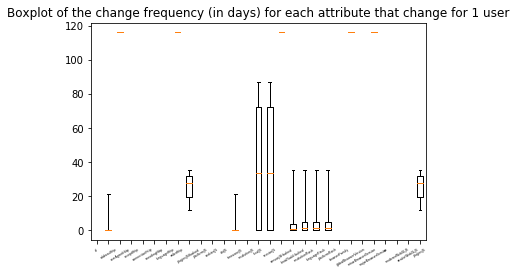

In [208]:
#frequency of changes of each attribute in time (days) (for 1 person) (Tout le monde change-il aussi souvent ?)

person=df_consistent[df_consistent['id']== "c3af36ba-81f4-4652-9523-44f2217dc0f0"]

L=[]
attribute_not_change = []
for attribute in attributes_to_analyze:
    new_t= person[attribute]
    list_new_t=list(new_t)

    new_date = person['creationDate']
    list_new_date = list(new_date)

    first_value = list_new_date[0]
    diff=[]
    list_df_diff_days=[]
    for i in range(1,len(list_new_t)):
        if list_new_t[i-1] != list_new_t[i]:
            d=list_new_date[i-1]
            f=list_new_date [i]
            e = datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S')
            g = datetime.datetime.strptime(f, '%Y-%m-%d %H:%M:%S')
            h = datetime.datetime.strptime(first_value, '%Y-%m-%d %H:%M:%S')
            diff.append((g-h).days)
        df_diff=pd.DataFrame(diff)

    number_values = df_diff.count()
    df_number_values = pd.DataFrame(number_values)
    
    if df_number_values.empty:
       # print('The attribute : {} does not change'.format(attribute))
        attribute_not_change.append(attribute)

    
    elif df_number_values.values == 1:
        
        list_df_diff=list(df_diff[0])
        list_df_diff_days.append(list_df_diff[0])
        df_list_df_diff_days=pd.DataFrame(list_df_diff_days)

        #print("The attribute is {}\n{}".format(attribute,df_list_df_diff_days))

    else : 
        list_df_diff=list(df_diff[0])
        #list_df_diff_days=[]
        list_df_diff_days.append(list_df_diff[0])

        for i in range(1,len(list_df_diff)):
            list_df_diff_days.append(list_df_diff[i]-list_df_diff[i-1])
            df_list_df_diff_days=pd.DataFrame(list_df_diff_days)

        #print("The attribute is {}\n{}".format(attribute,df_list_df_diff_days))
    L.append(list_df_diff_days)
plt.boxplot(L, whis = 'range')
plt.gca().xaxis.set_ticklabels(attributes_to_analyze,rotation=30, fontsize=3)
plt.title('Boxplot of the change frequency (in days) for each attribute that change for 1 user')   
#plt.savefig('MultipleBoxPlot.png')

df_attribute_not_change=pd.DataFrame(attribute_not_change)
print("The attributes that do not change are :\n {}".format(df_attribute_not_change))

#"whis = 'range' " pour que les moustaches soient étendues jusqu'aux valeurs minimum et maximum

                                      acceptHttp  addressHttp  browserFamily  \
user                                                                           
c3af36ba-81f4-4652-9523-44f2217dc0f0         0.0     0.882850            0.0   
2bef0281-b2d9-41ac-967c-45835e5ba8c0         0.0     0.322188            0.0   
efca79c2-0b12-4ce7-a28f-68ad9193990d         0.0     0.031104            0.0   
77aae6f6-0bbd-4138-baa4-142c1e4dddcd         0.0     0.162921            0.0   
bc19c32d-a271-4dd7-b5e6-62d36d1a3128         0.0     0.118474            0.0   
f61809d2-a428-4a2c-81e4-461ea9908687         0.0     0.069930            0.0   
d4be492d-c9ee-46a0-b1ab-076386b61b85         0.0     0.895377            0.0   
68942969-0475-4a26-931b-d1d8043a659c         0.0     0.748649            0.0   
31fa27b8-6c4d-47b2-8566-b4af4d9ca9e8         0.0     0.755435            0.0   
c17f5405-360e-43d7-9b50-bccf6faf2207         0.0     0.746795            0.0   
b8f4eb79-baaf-442b-ada2-5bcd5cf89df4    

{'whiskers': [<matplotlib.lines.Line2D at 0x7f03cdefe4a8>,
  ...],
 'caps': [<matplotlib.lines.Line2D at 0x7f03cde6e860>,
  ...],
 'boxes': [<matplotlib.lines.Line2D at 0x7f03d5187198>,
  ...],
 'medians': [<matplotlib.lines.Line2D at 0x7f03cde6e898>,
  ...],
 'fliers': [<matplotlib.lines.Line2D at 0x7f03cde6eda0>,
  ...],
 'means': []}

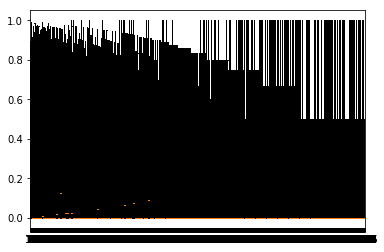

In [36]:
L=[]
for user_id in df_user_more_2_fingerprints['index']:
    #dict["1id"]=user_id
    dict_df={}
    dict_df["user"]=user_id
    df_filtered_id = df_consistent[df_consistent['id']==user_id]
    for attribute in attributes_to_analyze:
        counter=0
        first_value = df_filtered_id.iloc[0][attribute]
        for index, row in df_filtered_id.iterrows():
            if row[attribute]!= first_value:
                counter=counter+1
                first_value=row[attribute]
            else : 
                first_value=first_value
        
        frequency=counter/len(df_filtered_id[attribute])
        dict_df[attribute]=frequency
    L.append(dict_df)

#print(L)    
df_L=pd.DataFrame(L)
table=df_L.set_index("user")
print(table)

dict_stat=[]
for attribute in table:
    moyenne = np.mean(table[attribute])
    dict_stat.append({
        "attribute":attribute,
        "mean":moyenne
    })
df_stat = pd.DataFrame(dict_stat)
df_stat = df_stat.set_index("attribute")
print(df_stat)

plt.boxplot(table, whis = 'range')

In [84]:
#frequency of changes of each attribute in time (days)
List_frequency_attributes=[]

#take only users with more 2 fingerprints to see the evolution in fingerprints for each user
for user_id in df_user_more_2_fingerprints['index']:
    dict_df={}
    dict_df["user"]=user_id
    df_filtered_id = df_consistent[df_consistent['id']==user_id]
    
    #for each attribute, we store the date of creation and the first value of the first fingerprint of user
    for attribute in attributes_to_analyze:
        first_value_date = df_filtered_id.iloc[0]['creationDate']
        liste_time=[]
        first_value = df_filtered_id.iloc[0][attribute]
        
        #count the number of days between each changes in the attribute then store it in a list
        for index, row in df_filtered_id.iterrows():
            if row[attribute]!= first_value:
                date_next=row['creationDate']
                transform_date_next = datetime.datetime.strptime(date_next, '%Y-%m-%d %H:%M:%S')
                transform_date_previous = datetime.datetime.strptime(first_value_date, '%Y-%m-%d %H:%M:%S')
                liste_time.append((transform_date_next-transform_date_previous).days)
                first_value_date=row['creationDate']
                first_value=row[attribute]
            else : 
                first_value_date=first_value_date
        
        #do the average of the list obtained previously and adds it in dictionary 
        mean_liste=np.mean(liste_time)
        dict_df[attribute]=mean_liste
    List_frequency_attributes.append(dict_df)

#create a dataframe for a better visualization and put in index the users    
df_List_frequency_attributes=pd.DataFrame(L)
table=df_List_frequency_attributes.set_index("user")
table

/home/spirals/PycharmProjects/stage/myvenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/spirals/PycharmProjects/stage/myvenv/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


acceptHttp  addressHttp  browserFamily  \
user                                                                           
c3af36ba-81f4-4652-9523-44f2217dc0f0         NaN     0.117647            NaN   
2bef0281-b2d9-41ac-967c-45835e5ba8c0         NaN     1.537736            NaN   
efca79c2-0b12-4ce7-a28f-68ad9193990d         NaN    16.400000            NaN   
77aae6f6-0bbd-4138-baa4-142c1e4dddcd         NaN     0.448276            NaN   
bc19c32d-a271-4dd7-b5e6-62d36d1a3128         NaN     9.254237            NaN   
f61809d2-a428-4a2c-81e4-461ea9908687         NaN    17.133333            NaN   
d4be492d-c9ee-46a0-b1ab-076386b61b85         NaN     1.038043            NaN   
68942969-0475-4a26-931b-d1d8043a659c         NaN     1.075812            NaN   
31fa27b8-6c4d-47b2-8566-b4af4d9ca9e8         NaN     1.111511            NaN   
c17f5405-360e-43d7-9b50-bccf6faf2207         NaN     2.000000            NaN   
b8f4eb79-baaf-442b-ada2-5bcd5cf89df4         NaN     1.520000            NaN   
ac7c0dae-6fe3-48e3-97b7-ab62571a0eb1         NaN     9.680000            NaN   
f4f25187-82c7-4265-9bf9-71bc8ed1701f         NaN     2.260870            NaN   
907af844-581a-4044-8ddb-8bcc91df32f9         NaN     1.358140            NaN   
d7969eaf-cd67-4ac5-b060-393d864f8525         NaN     2.658065            NaN   
c28aa37d-571e-4b43-bf01-aa14eeb765e7         NaN     1.738095            NaN   
2f38656b-76d5-4b46-a81d-c90b96495673         NaN     4.849057            NaN   
7a26546e-0a07-423c-9e97-0ef56212920d         NaN     0.830097            NaN   
893c10a4-b913-4fd9-a2a6-6a0ea7a1cc62         NaN    49.000000            NaN   
39107c52-98c9-4a75-b505-271294fac465         NaN     1.000000            NaN   
628a06f1-ca1e-4e6e-9b38-5e23da554b53         NaN     5.408451            NaN   
a5f01fef-bcda-49d6-b726-2fe0d7a4e928         NaN     2.204545            NaN   
f258256f-54bc-46fc-baca-9df34d5ff3ac         NaN          NaN            NaN   
3f18eefa-8d4c-4381-b642-f2feca50f63a         NaN     1.969231            NaN   
595525a1-8ff1-493d-bdef-74ecb74d182b         NaN     4.310345            NaN   
8b10f12f-516a-44ee-9e79-134d040d1ef4         NaN     1.647541            NaN   
2c383b80-2256-4ece-81d4-c81290a10a14         NaN     1.119048            NaN   
1603f573-55cc-47f7-93a2-29ea605789ce         NaN     0.992424            NaN   
2657b615-04b0-4c11-8343-1245c9c07676         NaN          NaN            NaN   
718eaf95-e9e2-42a2-ba4c-5316b5f45fdf         NaN     3.476190            NaN   
...                                          ...          ...            ...   
c61cd672-3d7c-4b4b-8c7b-79fb849708b5         NaN          NaN            NaN   
fed94907-ecad-4dfc-97f4-0377d21780e7         NaN          NaN            NaN   
4da4649f-e7b2-4970-8c5b-cbdc27e946f5         NaN          NaN            NaN   
0fef48a3-425e-4d42-82ae-771a9afe232c         NaN          NaN            NaN   
c257d9d2-d515-403f-9aa8-f113c9c8eb0a         NaN     0.000000            NaN   
0dc38ec3-d11e-4628-ad72-b4eb3eb9930f         NaN          NaN            NaN   
48e31e26-1477-49a0-be93-ae668137cace         NaN          NaN            NaN   
1aa89e95-a5b1-4dae-9555-ec654a73f50d         NaN     6.000000            NaN   
6e3fc3d1-16dd-46f1-9c5d-7e483c648d3d         NaN     0.000000            NaN   
ffe8a4f4-6cc3-4c0c-8ce7-9dc1b36e03a1         NaN    49.000000            NaN   
c83cfb60-702e-4f31-9b58-cebac2430797         NaN          NaN            NaN   
0b1c5151-5973-4ca3-aa4a-fc32e8244d16         NaN          NaN            NaN   
2f598228-1960-48f0-9bb2-dd17dd6a0bfa         NaN          NaN            NaN   
dfeeecdd-d52b-4b18-8bfd-181a0531fb4f         NaN          NaN            NaN   
1f34809f-ede4-4ee9-9201-29235139f4f9         NaN          NaN            NaN   
9378ea73-ca10-46d8-acb4-14a98b155f3a         NaN    24.000000            NaN   
09ca73d6-c5c2-4103-b2ac-7837ccdc7594         NaN     4.000000            NaN   
e2f5054f-1478-4859-914e-3427638ba497  

In [85]:
#statistics about the frequency of attribute changes over time (in days)
dict_stat=[]
for attribute in table:
    Q25 = table[attribute].quantile(0.25,interpolation='midpoint')
    median = table[attribute].quantile(0.5,interpolation='midpoint')
    Q75 = table[attribute].quantile(0.75,interpolation='midpoint')
    #print("{}: mediane:{}".format(column,median))
    mean=table[attribute].mean()
    dict_stat.append({
        "attribute":attribute,
        "Q25":Q25,
        "median":median,
        "Q75":Q75
    })
    
#create a dataframe for the visualization
df_stat = pd.DataFrame(dict_stat)

#put in index the name of attributes
df_stat = df_stat.set_index("attribute")

#replace NaN by 'Never'
for column in df_stat:
    df_stat[column].replace(to_replace=[NaN], value='Never', inplace=True)
df_stat  

df_stat_order = df_stat[['Q25','median','Q75']]
df_stat_order

Q25    median      Q75
attribute                                        
acceptHttp            0.444444  0.888889  2.19444
addressHttp            2.21939   7.24286  18.9545
browserFamily            Never     Never    Never
canvasJSHashed              10     36.75       84
connectionHttp           Never     Never    Never
cookiesJS                    0         1     8.75
dntJS                        0         1       16
encodingHttp            11.375      55.5      128
fontsFlashHashed       2.33333       7.5       20
globalBrowserVersion        19        37  46.4722
id                       Never     Never    Never
languageFlash          3.06436   11.3889       30
languageHttp                 1   9.54545       35
localJS                   0.25         7       27
majorBrowserVersion         20        37     46.5
minorBrowserVersion        5.5      15.5     31.5
orderHttp                    1        13       64
os                       Never     Never    Never
platformFlash          3.34014    11.625  29.7083
platformJS                   1      6.75  38.7143
pluginsJS                    6   18.6667       37
pluginsJSHashed        7.51471   20.7949  39.0625
rendererWebGLJS              5      24.5  64.6667
resolutionFlash              2   7.63333  21.8221
resolutionJS           1.83482   6.33333     20.5
sessionJS                    0         7       27
timezoneJS                  21        48      114
userAgentHttp          10.6039   21.3571  38.4643
vendorWebGLJS              4.3   21.0556       63

In [49]:
#pour avoir la date de changement a cote de la valeur du changement (en cours)
for user_id in df_user_more_2_fingerprints['index']:
    table_id = df_consistent[df_consistent['id']== user_id]
    table_id_attribute_changes = table_id['timezoneJS']
    
    list_table_id_attribute_changes = list(table_id_attribute_changes)
    #print(table_id_attribute_changes)
    date_attribute_changes=[]
   # for value in table_id_attribute_changes:
      #  diff=[]
    for i in range(1,len(list_table_id_attribute_changes)):
        if list_table_id_attribute_changes[i-1] != list_table_id_attribute_changes[i]:
            date_attribute_changes.append({
              "cle": key,
              "Date":list_table_id_attribute_changes[i]
            })
    df_date_attribute_changes = pd.DataFrame(date_attribute_changes)
    print(df_date_attribute_changes)
   # df_year_month = pd.DataFrame(year_month)

     Date    cle
0    -120  66309
1     420  66309
2     -60  66309
3    -120  66309
4     -60  66309
5     360  66309
6    -120  66309
7     -60  66309
8    -120  66309
9     -60  66309
10   -120  66309
11    -60  66309
12   -120  66309
13    -60  66309
14    240  66309
15   -120  66309
16    300  66309
17   -120  66309
18    -60  66309
19   -120  66309
20    420  66309
21   -120  66309
22    240  66309
23    -60  66309
24   -120  66309
25    -60  66309
26   -120  66309
27    240  66309
28    -60  66309
29    240  66309
..    ...    ...
450   -60  66309
451   360  66309
452   -60  66309
453   420  66309
454   480  66309
455   -60  66309
456     0  66309
457   360  66309
458   -60  66309
459   360  66309
460   -60  66309
461   300  66309
462  -120  66309
463   -60  66309
464   360  66309
465   -60  66309
466   360  66309
467   300  66309
468   -60  66309
469   300  66309
470     0  66309
471   -60  66309
472   300  66309
473   -60  66309
474   300  66309
475   -60  66309
476   360  663

Empty DataFrame
Columns: []
Index: []
   Date    cle
0   300  66309
1   360  66309
   Date    cle
0   360  66309
1   420  66309
2   300  66309
3   360  66309
4   300  66309
5   360  66309
6   480  66309
7   360  66309
8   300  66309
   Date    cle
0  -480  66309
1  -540  66309
2   300  66309
3   240  66309
4   420  66309
5   240  66309
6   360  66309
7   300  66309
   Date    cle
0   300  66309
1   -60  66309
2  -120  66309
3   -60  66309
4  -600  66309
   Date    cle
0  -600  66309
1  -660  66309
   Date    cle
0   -60  66309
   Date    cle
0   -60  66309
   Date    cle
0   -60  66309
1   360  66309
2   -60  66309
   Date    cle
0     0  66309
    Date    cle
0    240  66309
1    420  66309
2    300  66309
3    420  66309
4    480  66309
5    300  66309
6    480  66309
7    300  66309
8    480  66309
9    300  66309
10   480  66309
11   420  66309
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   -60  66309
   Date    cle
0  -120  66309
1   -60  66309
Empty DataFrame
Columns: [

   Date    cle
0   420  66309
1   480  66309
   Date    cle
0  -120  66309
Empty DataFrame
Columns: []
Index: []
   Date    cle
0     0  66309
1   -60  66309
2  -120  66309
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   360  66309
1   300  66309
2   240  66309
   Date    cle
0   -60  66309
   Date    cle
0  -180  66309
   Date    cle
0   -60  66309
1  -120  66309
2   -60  66309
   Date    cle
0   480  66309
1   420  66309
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   -60  66309
   Date    cle
0  -120  66309
   Date    cle
0   300  66309
   Date    cle
0   300  66309
1   240  66309
   Date    cle
0  -660  66309
   Date    cle
0   -60  66309
   Date    cle
0  -120  66309
1   -60  66309
Empty DataFrame
Columns: []
Index: []
   Date    cle
0  -480  66309
1  -180  66309
   Date    cle
0  -120  66309
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   -60  66309
   Date    cle
0     0  66309
   Date    cle
0   240  66309
1   420  66309
2   240  66309
3   300  66309


   Date    cle
0   -60  66309
   Date    cle
0   300  66309
1   240  66309
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   240  66309
   Date    cle
0   -60  66309
Empty DataFrame
Columns: []
Index: []
   Date    cle
0  -480  66309
   Date    cle
0   -60  66309
1     0  66309
   Date    cle
0   -60  66309
   Date    cle
0   420  66309
1   -60  66309
2     0  66309
   Date    cle
0   240  66309
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   240  66309
   Date    cle
0  -120  66309
1   -60  66309
   Date    cle
0   300  66309
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   -60  66309
   Date    cle
0   420  66309
1   360  66309
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   180  66309
   Date    cle
0   240  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0  -120  66309
   Date    cle
0   420  66309
1   480  66309
2   420  66309
   Date    cle
0   -60  66309
1  -120  66309
2   300  66309
   Date    cle

Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   -60  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0  -120  66309
   Date    cle
0  -120  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   240  66309
   Date    cle
0     0  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   -60  66309
   Date    cle
0   -60  66309
   Date    cle
0  -660  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   -60  66309
   Date    cle
0  -120  66309
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   300  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0  -120  66309
1     0  66309
2  -120  66309
Empty DataFrame
Columns: []
Index: []
   Date    cle
0  -120  66309
   Date   

   Date    cle
0   180  66309
   Date    cle
0  -120  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   -60  66309
   Date    cle
0   -60  66309
Empty DataFrame
Columns: []
Index: []
   Date    cle
0  -180  66309
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   240  66309
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   -60  66309
Empty DataFrame
Columns: []
Index: []
   Date    cle
0  -120  66309
1   -60  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0  -120  66309
   Date    cle
0   360  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   240  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0  -180  66309
   Date    cle
0   300  66309
Empty DataFrame
Columns: 

Empty DataFrame
Columns: []
Index: []
   Date    cle
0  -180  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   300  66309
   Date    cle
0  -120  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0  -360  66309
1  -180  66309
2  -360  66309
3   360  66309
4  -360  66309
   Date    cle
0   -60  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   -60  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []


Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   420  66309
1   480  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   300  66309
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   240  66309
Empty DataFrame
Columns: []
Index: []
   Date    cle
0  -120  66309
   Date    cle
0  -180  66309
   Date    cle
0   -60  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   240  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   -60  66309
1  -120  66309
2   -60  66309
3  -120  66309
   Date    cle
0  -240  66309
1  -180  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty Dat

   Date    cle
0  -120  66309
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   240  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   -60  66309
Empty DataFrame
Columns: []
Index: []
   Date    cle
0  -120  66309
   Date    cle
0   300  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   420  66309
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   300  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   240  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []


Empty DataFrame
Columns: []
Index: []
   Date    cle
0  -240  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0  -120  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   360  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0  -120  66309
1   -60  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
I

   Date    cle
0  -120  66309
   Date    cle
0    60  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   420  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: [

Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0  -120  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   360  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
   Date    cle
0   -60  66309
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: [